In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [3]:
import yfinance as yf
stock_symbol = 'TWTR'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-03-18,37.459999,39.049999,37.180000,37.770000,37.770000,35938500
501,2022-03-21,37.700001,37.889999,36.639999,37.439999,37.439999,20298700
502,2022-03-22,37.639999,39.049999,37.619999,38.430000,38.430000,17162100
503,2022-03-23,38.000000,38.750000,37.580002,38.000000,38.000000,12993600
504,2022-03-24,38.330002,39.090000,38.230000,38.820000,38.820000,17819845


#### Visualizing the Real Stock Trend

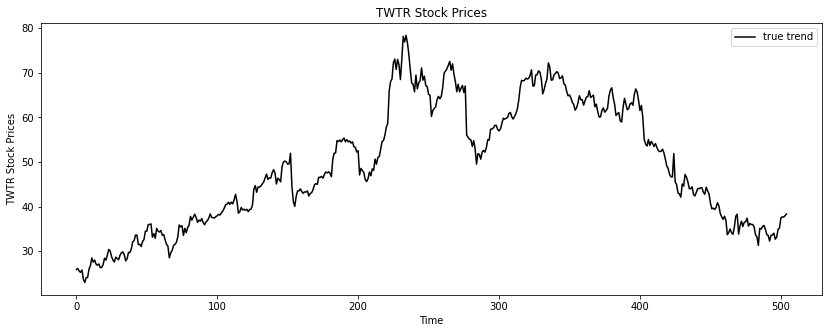

In [4]:
plt.figure(figsize=(14,5))
plt.plot(data['Open'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [5]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [6]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,25.850000,27.459999,24.520000,25.969999,25738800
1,26.150000,27.030001,25.629999,26.410000,20435300
2,25.559999,25.830000,24.760000,25.290001,22069300
3,25.250000,25.940001,24.600000,25.590000,20720800
4,25.790001,26.330000,24.400000,24.559999,24993400


In [7]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.05148122, 0.06786775, 0.04023095, 0.05401939, 0.20829276])

In [8]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,0])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((385, 60, 5), (385,))

#### Preparaing testing data

In [9]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
           Open       High        Low      Close    Volume
 385  61.040001  61.160000  57.639999  58.389999  17381300
 386  59.209999  60.669998  58.820000  59.860001  12006500
 387  58.950001  61.709999  58.790001  61.290001  10648100
 388  62.200001  64.360001  62.150002  63.970001  15010400
 389  64.250000  64.339996  63.310001  63.680000   8098800)

In [10]:
df = scaler.transform(df)
df[0]

array([0.68713874, 0.65733776, 0.65710555, 0.64768359, 0.12944366])

In [11]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,0])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [12]:
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

array([1.80635836e-02, 1.74916914e-02, 1.86254415e-02, 1.83116656e-02,
       9.43453190e-09])

In [13]:
scale = 1/8.50296711e-04
scale

1176.0600588751424

In [14]:
y_test = y_test*scale

#### GRU - Gated Recurrent Unit

In [15]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [16]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [17]:
model = Sequential()

# 1st layer
model.add(GRU(units=40,activation='relu',return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))

# 2nd layer
model.add(GRU(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.2))

# 3rd layer
model.add(GRU(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.2))

# Final layer
model.add(GRU(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 40)            5640      
                                                                 
 dropout (Dropout)           (None, 60, 40)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 60)            18360     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 gru_2 (GRU)                 (None, 60, 80)            34080     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 gru_3 (GRU)                 (None, 120)               7

In [18]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [19]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [20]:
def first_forecast():
    history = model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred*scale
    return history,y_pred

In [21]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
13/13 [==============================] - 13s 276ms/step - loss: 0.1209 - accuracy: 0.0000e+00
Epoch 2/300
13/13 [==============================] - 4s 292ms/step - loss: 0.0217 - accuracy: 0.0026
Epoch 3/300
13/13 [==============================] - 4s 301ms/step - loss: 0.0210 - accuracy: 0.0026
Epoch 4/300
13/13 [==============================] - 3s 259ms/step - loss: 0.0210 - accuracy: 0.0026
Epoch 5/300
13/13 [==============================] - 4s 281ms/step - loss: 0.0199 - accuracy: 0.0026
Epoch 6/300
13/13 [==============================] - 4s 342ms/step - loss: 0.0164 - accuracy: 0.0026
Epoch 7/300
13/13 [==============================] - 4s 287ms/step - loss: 0.0147 - accuracy: 0.0026
Epoch 8/300
13/13 [==============================] - 4s 292ms/step - loss: 0.0146 - accuracy: 0.0026
Epoch 9/300
13/13 [==============================] - 4s 307ms/step - loss: 0.0134 - accuracy: 0.0026
Epoch 10/300
13/13 [==============================] - 5s 355ms/step - los

#### Calculating the Accuracy using RMSE

In [22]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[74.1937538091273]

In [23]:
# RMSE - Root Mean Squared Error 
temp = 1 - np.sqrt(np.mean(np.square((y_test - result_forecast[0])/y_test)))
temp*100

65.10372517630792

#### Visualization

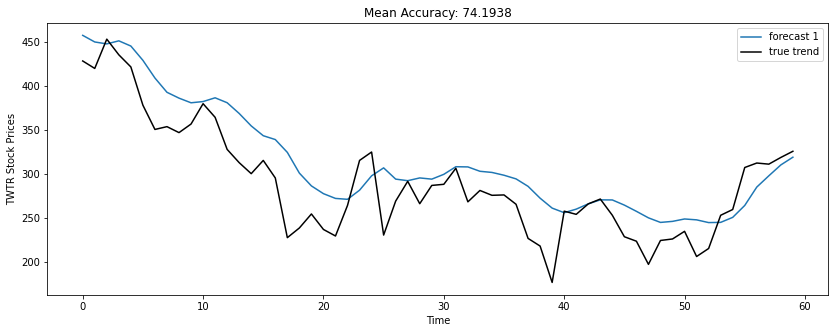

In [24]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

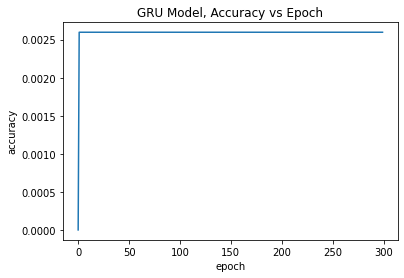

In [26]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('GRU Model, Accuracy vs Epoch')
plt.show()

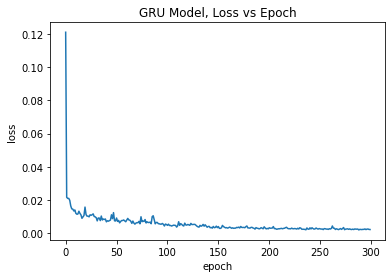

In [27]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('GRU Model, Loss vs Epoch')
plt.show()